# Importing library

In [ ]:
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from pytorch_metric_learning.losses import NTXentLoss
from torch.optim.lr_scheduler import StepLR
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#  Load the dataset

In [ ]:
training_data = datasets.CIFAR10('cifar10_train_image', train=True, download=True, transform=transforms.ToTensor())
testing_data = datasets.CIFAR10('cifar10_test_image', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Since contrastive learning generally is computationally heavier than your typical supervised learning, the cifar10 data used for this task will only be limited to 3000 data(image) (1000 for each class). The classes are airplane, automobile and ship. Obviously, the label wont be used since it is a self-supervised learning, but the label will be useful to evaluate the model's perfomance

In [ ]:
selected_classes = [0, 1, 8]
#airplane, automobile, ship

max_samples_per_class = 1000

# Filter the training data to only include the selected classes
train_indices = []
for idx, label in enumerate(training_data.targets):
    if label in selected_classes:
        train_indices.append(idx)


limited_train_indices = []
for selected_class in selected_classes:
    class_indices = [i for i in train_indices if training_data.targets[i] == selected_class]
    
    limited_train_indices.extend(class_indices[:max_samples_per_class])

# Create a subset with the limited data
subset_training_data = Subset(training_data, limited_train_indices)

# List of data's class

In [ ]:
class_names = ['airplane', 'automobile', 'ship']
print(class_names)

['airplane', 'automobile', 'ship']


# Sample image

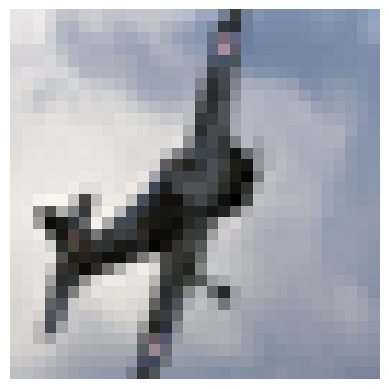

In [ ]:
rand_image,rand_label = subset_training_data[420]

topil = transforms.ToPILImage()
plt.imshow(topil(rand_image))
plt.axis('off')
plt.show()

# Augmentation function

In [ ]:
augment_transform_sample = transforms.Compose([
    #Data augmentation
    transforms.Resize(224),

    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),

    transforms.RandomGrayscale(p=0.2),

   # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
augment_transform = transforms.Compose([
    #Data augmentation
    transforms.Resize(224),

    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),

    transforms.RandomGrayscale(p=0.2),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Augmented sample image

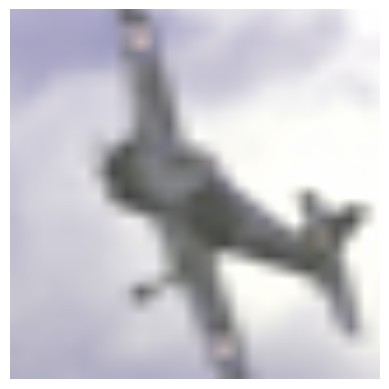

In [ ]:
trasformed_image = augment_transform_sample(rand_image)

plt.imshow(topil(trasformed_image))
plt.axis('off')
plt.show()

#  Building the model

In [ ]:
resnet_model = models.resnet50(weights=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class SimCLR(torch.nn.Module):
    def __init__(self, encoder = resnet_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.feature_dim = self.encoder.fc.in_features

        self.encoder.fc = torch.nn.Identity()

        self.projection_head = torch.nn.Sequential(
            torch.nn.Linear(self.feature_dim, self.feature_dim),
            torch.nn.BatchNorm1d(self.feature_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.feature_dim, projection_dim),
            torch.nn.BatchNorm1d(projection_dim)
        )

    def forward(self, x, return_features=False):

        features = self.encoder(x)

        if return_features:
            return features

        projections = self.projection_head(features)
        projections = torch.nn.functional.normalize(projections,dim=1)

        return projections


In [ ]:
train_data_loader = DataLoader(subset_training_data, batch_size=80, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCLR().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#InfoNCE loss
loss_fn = NTXentLoss(temperature=0.1)

#scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
def trainModel(epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_data_loader:
            images = batch[0].to(device)

            aug1 = augment_transform(images).to(device)
            aug2 = augment_transform(images).to(device)

            z1 = model(aug1)
            z2 = model(aug2)

            embeddings = torch.cat([z1, z2], dim=0)
            labels = torch.cat([torch.arange(len(z1))] * 2).to(device)
            loss = loss_fn(embeddings, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        #scheduler.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_data_loader):.4f}")


In [ ]:
trainModel(5)

Epoch [1/5], Loss: 0.5131
Epoch [2/5], Loss: 0.1747
Epoch [3/5], Loss: 0.0962
Epoch [4/5], Loss: 0.0901
Epoch [5/5], Loss: 0.0682


# Eval

limit testing data from dataset library, since we just want to visualize model's performance

In [ ]:
selected_classes = [0, 1, 8]
#airplane, automobile, ship

max_samples_per_class = 11

# Filter the training data to only include the selected classes
test_indices = []
for idx, label in enumerate(testing_data.targets):
    if label in selected_classes:
        test_indices.append(idx)


limited_testing_indices = []
for selected_class in selected_classes:
    class_indices = [i for i in test_indices if testing_data.targets[i] == selected_class]
   
    limited_testing_indices.extend(class_indices[:max_samples_per_class])

# Create a subset with the limited data
subset_testing_data = Subset(testing_data, limited_testing_indices)

In [ ]:
test_loader = DataLoader(subset_testing_data, batch_size=4)

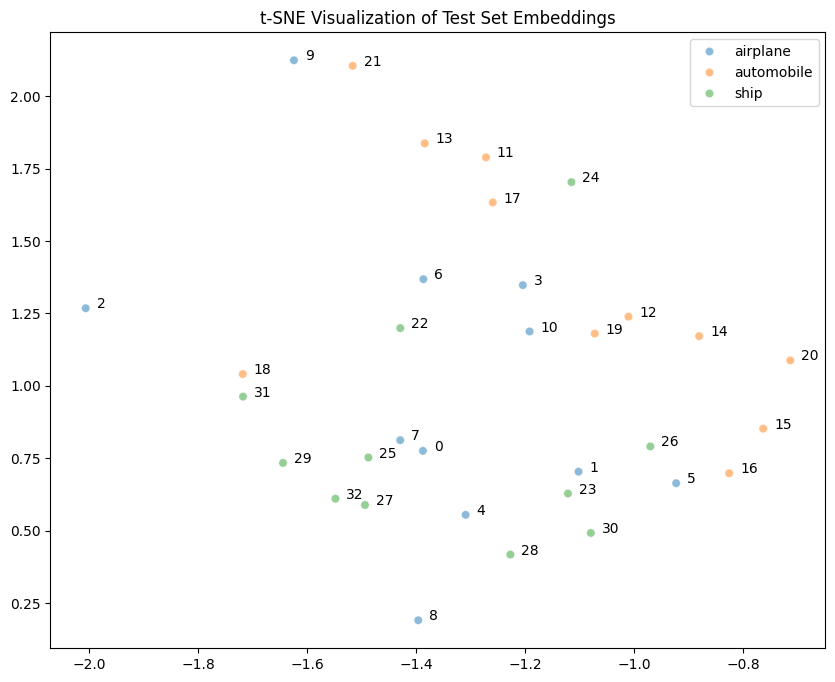

In [ ]:
model.eval()

embeddings = []
labels = []

with torch.no_grad():
    for sample in test_loader:
        
        images = sample[0].to(device)
        targets = sample[1]  

        features = model(images, return_features=True)  
        embeddings.append(features.cpu())
        labels.append(targets)

embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()

label_mapping = {0: "airplane", 1: "automobile", 8: "ship"}
labels_named = np.array([label_mapping[label] for label in labels])

# Perform t-SNE to reduce dimensions
h_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings)

plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x=h_embedded[:, 0], y=h_embedded[:, 1], hue=labels_named,
                     alpha=0.5, palette="tab10")

# Add annotations to identify data points (optional)
annotations = list(range(len(h_embedded[:, 0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + .02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:, 0]),
             pd.Series(h_embedded[:, 1]),
             pd.Series(annotations),
             plt.gca())

plt.title('t-SNE Visualization of Test Set Embeddings')
#plt.legend(['airplane','automobile','ship'])
plt.show()

Based on the graph above, the self-supervised model (SimCLR) doesnot perform well. The model are not able to distinguish image's class really well from the other image's class. Some blue dot (airplane) image are close to green dot (ship) image. There are several reasons to why this model are not performing really well. Some of which includes: batch size, the temperature's parameter on infoNCE loss, and the number of training data used. 

Batch size: Generally, the higher the batch size, the better the performance, but higher batch size uses higher memory which wasnt available during the training process. Batch size such as 128 or even 256 and higher will produce better performance. Higher batch size will allow for infoNCE loss to compare more positve pairs with other negative or positive pairs resulting in better generalizability

Temperature's parameter on infoNCE: this is a threshold that helps the model "distinguish" image representation, the higher the value, the stricter the model on "distinguishing" the image representation.

Number of training data: The higher the better since the model can compare more positive pairs and negative pairs, but higher number of training data will takes significantly more time to calculate infoNCE loss resulting in longer training time